# IN-STK5000/9000 - Medical Project

## Part 1 - Historical Data

Prerequesites: numpy, scipy, pandas, maplotlib, seaborn, sklearn, shap (and counting)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances   
from sklearn.linear_model import LogisticRegression

from scipy.spatial.distance import sokalmichener

import shap

from project_module import kmeans_cluster_data

sns.set()

In [2]:
# for reproducibility
SEED = 1337
np.random.seed(SEED)

# 1.1 - Discovering structure in the data

It is uncertain if the symptoms present are all due to
the same disease, or if they are different conditions with similar symptoms. Looking at the
data (including symptoms), estimate whether a single-cause model is more likely than a multiplecause model. You can use anything, ranging from histograms or simple clustering algorithms
to a hierarchical Bayesian model.   

***  




### Information about the data

This is historical data in three tables.

X: observations about each patient
A: treatment
Y: outcome of treatment

The data is organised in the following files:

historical.dat: all the tables in one file (matlab format)
historical_X.dat: the X data
historical_A.dat: the A data
historical_Y.dat: the Y data

Modelling the X data can be done through both unsupervised and supervised models. As some of the genome features might be irrelevant, it is probably a good idea to try and filter them out somehow. In later parts of the project, you will be able to perform experiments to narrow done the important genes. For the latter approach, you can combine the last two columns into a classification label, which should give you a cross-validation score of between 60-70%.



In [3]:
feature_path = "../../data/medical/historical_X.dat"
action_path = '../../data/medical/historical_A.dat'
outcome_path ='../../data/medical/historical_Y.dat'

In [4]:
X = pd.read_csv(feature_path, delimiter=" ", names=["sex", "smoker"] \
                                           + [f"gen_{i}" for i in range(1, 127)] \
                                           + ["symptom_1","symptom_2"])
S = X[["symptom_1", "symptom_2"]]
X

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
0,0,0,0,0,1,1,0,0,1,1,...,0,1,1,0,1,1,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
9996,1,0,1,1,1,0,1,1,0,0,...,1,0,1,1,0,0,1,0,0,0
9997,0,0,1,0,1,0,0,1,0,1,...,1,1,1,0,1,1,1,0,0,0
9998,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


With the data, we asssume that every individual has some underlying condition, despite not showing the same (or any) symptoms. 

For these two symptoms, we have 128 binary features. If it is a single-cause model, a single characteristic of each individual is sufficient to explain the symptoms. If that is not the case, we have a multiple cause model. 

Before looking further into the dataset, it is important that we address the existence of confounder variables.  
Confounder variables will likely play a role in determining the symptoms considering we have a fairly limited dataset regarding the individuals.   The confounder variables could for instnace be associated with parents genetical data, lifestyle ... among many other considerable attributes absent from this dataset. The relationships we assume can be represented as a graphical model as such:

$Z \rightarrow X_{\setminus S} \rightarrow S \rightarrow (a \rightarrow y) \leftarrow \pi$    
$Z \rightarrow S$

Z - confounder variable(s)  
X - attributes in dataset  
S - symptoms  
a - action  
y - outcome  
$\pi$ - policy  

On the contrary, even if we chose to ignore confounder variables, should we believe there is a multi-cause model in the dataset?

Before making assumptions about the attribute's relation to the symptoms, we should look at the distribution in our dataset.

<AxesSubplot:>

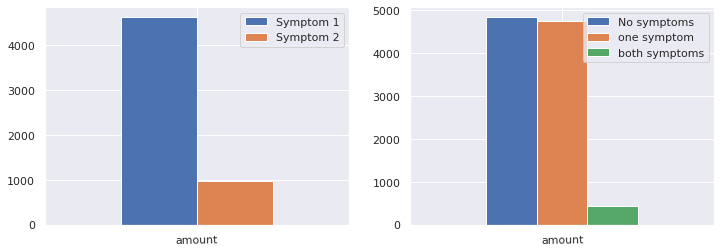

In [75]:
s1, = X[["symptom_1"]].to_numpy().T
s2, = X[["symptom_2"]].to_numpy().T
X_symptoms = s1 + s2
none, one, both = [(X_symptoms == i).sum() for i in range(3)]
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame({"Symptom 1": s1.sum(), "Symptom 2": s2.sum()}, index=["amount"]).plot.bar(rot=1, ax=ax1)
pd.DataFrame({"No symptoms": none, "one symptom": one, "both symptoms": both}, index=["amount"]).plot.bar(rot=1, ax=ax2)

Notice how symptom 2 is underrepresented in the dataset in addition to the fact that half of the dataset describes individuals with no reported symptoms (assuming that the labels are correct)

For visual representation of the dataset, we use PCA. As shown by the computation below, our visualization
(pca of 2 components) only captures 32% of the variation, whist 70 components are required to capture 90% of the variation.
It is important to consider this before making any assumptions from the plots.  
Nontheless, the representation can still give us some cues about the relations of the datapoints.

In [8]:
test_model = PCA(n_components=X.shape[1], random_state=SEED)
test_model.fit(X)
score = np.cumsum(test_model.explained_variance_ratio_)
score[2], score[70]

(0.32643006110799566, 0.8995593171853962)

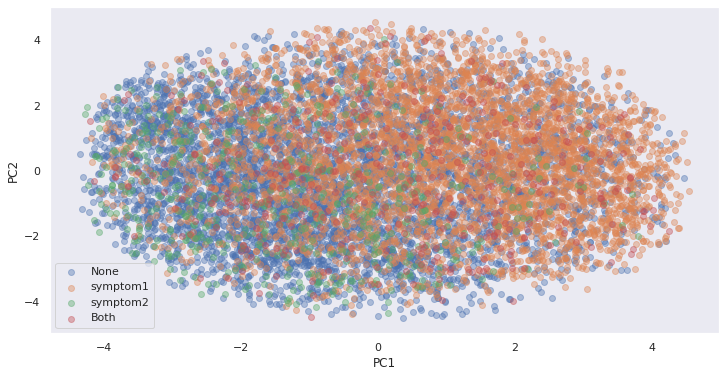

In [11]:
plt.subplots(figsize=(12, 6))
conds = [(s1 == j) & (s2 == i) for i in range(2) for j in range(2)]
for cond, label in zip(conds, ["None", "symptom1", "symptom2", "Both"]):
    plt.scatter(x1[cond], x2[cond], label=label, alpha=0.4)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
plt.legend()
plt.grid()

If we had a single cause model and we knew that single cause existed in X, the data would certainly be much more separate (even despite our visual limitations). However, we do see some separation, primarily between symptom 1 and no symptoms.

(0.6618, 0.08800879517699431)

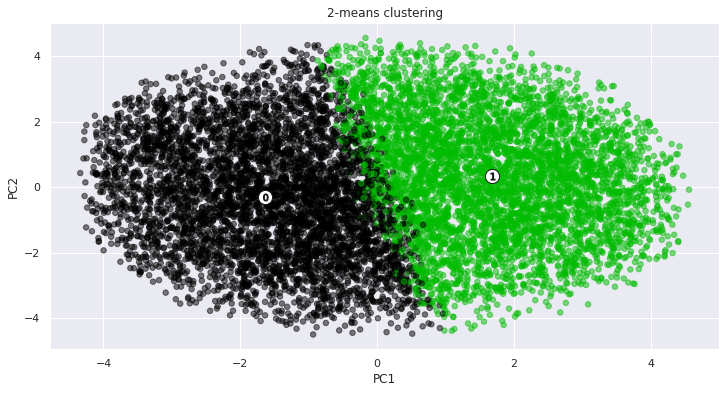

In [101]:
k2labels, _ = kmeans_cluster_data(X.to_numpy()[:, :-2], k=2)
acc_symptoms = np.mean(k2labels == S["symptom_1"].to_numpy())
cluster_score = silhouette_score(X, k2labels)
acc_symptoms, cluster_score

With a two-cluster model we get 66% accuracy on symptom 1 which is interesting considering that our mean silhouette score was almost zero (0.08)

So how do the data attributes relate to these symptoms? To find out, we look at the correlation matrix. Pandas built in function uses Pearson correlation coefficient. This works well on continous/numerical data, but is not appropriate for binary datasets, which is what we are using. The metric we decided on is the Jaccard-Needham similarity

In [5]:
from scipy.spatial.distance import jaccard
def jaccard_similarity(x1, x2):
    return 1 - jaccard(x1, x2)

# this jaccard function returns dissimilarity, so we subtract 1 by it to get the similarity
corr_jc = X.corr(method=jaccard_similarity)
corr_jc

,sex,smoker,gen_1,gen_2,gen_3,gen_4,gen_5,gen_6,gen_7,gen_8,...,gen_119,gen_120,gen_121,gen_122,gen_123,gen_124,gen_125,gen_126,symptom_1,symptom_2
sex,1.000000,0.262565,0.340029,0.344594,0.332142,0.333646,0.327568,0.335952,0.328073,0.327799,...,0.339973,0.331235,0.334356,0.334973,0.323148,0.328303,0.335589,0.360898,0.322988,0.092302
smoker,0.262565,1.000000,0.236687,0.212690,0.228070,0.203707,0.224311,0.229938,0.204194,0.215014,...,0.223488,0.201823,0.210427,0.217023,0.219744,0.218863,0.223744,0.222222,0.196382,0.141137
gen_1,0.340029,0.236687,1.000000,0.319943,0.534234,0.177856,0.372928,0.645867,0.183879,0.281395,...,0.500596,0.185370,0.339915,0.442299,0.398385,0.319324,0.588809,0.312228,0.224162,0.122882
gen_2,0.344594,0.212690,0.319943,1.000000,0.280035,0.383460,0.361213,0.276733,0.238402,0.220811,...,0.317210,0.215456,0.162075,0.260020,0.252080,0.479087,0.314460,0.469134,0.555983,0.111966
gen_3,0.332142,0.228070,0.534234,0.280035,1.000000,0.262958,0.337118,0.469918,0.254154,0.452621,...,0.596697,0.317131,0.442703,0.237838,0.429222,0.393935,0.433154,0.274900,0.258560,0.162580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gen_124,0.328303,0.218863,0.319324,0.479087,0.393935,0.357454,0.302793,0.214692,0.319432,0.316698,...,0.260307,0.255112,0.261346,0.190544,0.349380,1.000000,0.193151,0.380721,0.381000,0.107374
gen_125,0.335589,0.223744,0.588809,0.314460,0.433154,0.149563,0.418272,0.585762,0.192556,0.228519,...,0.546909,0.249405,0.351104,0.461639,0.420204,0.193151,1.000000,0.317800,0.207719,0.110230
gen_126,0.360898,0.222222,0.312228,0.469134,0.274900,0.462094,0.385250,0.331074,0.376045,0.351810,...,0.321857,0.359192,0.307945,0.353833,0.328031,0.380721,0.317800,1.000000,0.432704,0.077365
symptom_1,0.322988,0.196382,0.224162,0.555983,0.258560,0.624087,0.368662,0.269697,0.333054,0.373143,...,0.280867,0.319187,0.218754,0.243330,0.261589,0.381000,0.207719,0.432704,1.000000,0.082043


Using cosine similarity on this data could also be appropriate, so we will do a comparison, including cosine measures

In [6]:
def cosine_similarity(x1, x2):
    return (x1 @ x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

corr_cos = X.corr(method=cosine_similarity)

We select a similarity threshold to get the most important features

<AxesSubplot:title={'center':'using cosine similariy, threshold=0.6'}>

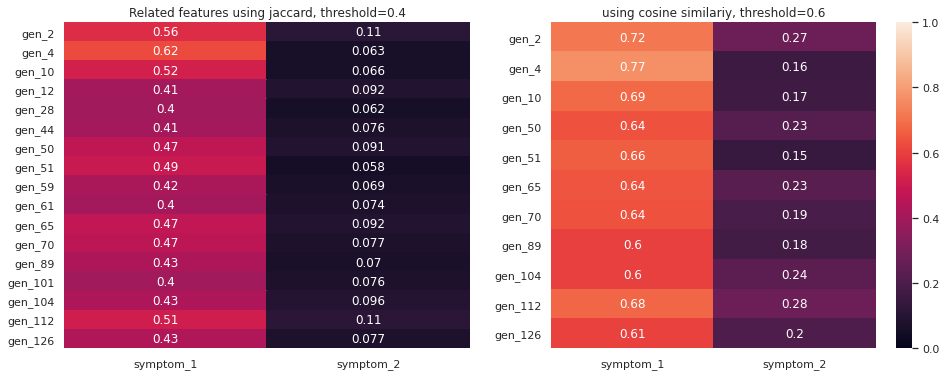

In [7]:
def get_cond(X_corr, threshold): 
    return (X_corr["symptom_1"] > threshold) | (X_corr["symptom_2"] > threshold)
most_corr_jc = corr_jc.loc[get_cond(corr_jc, 0.4)][["symptom_1", "symptom_2"]][:-2]
most_corr_cos = corr_cos.loc[get_cond(corr_cos, 0.6)][["symptom_1", "symptom_2"]][:-2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title(f"Related features using jaccard, threshold={0.4}")
ax2.set_title(f"using cosine similariy, threshold={0.6}")
sns.heatmap(most_corr_jc, annot=True, ax=ax1, vmin=0, vmax=1, cbar=False)
sns.heatmap(most_corr_cos, annot=True, ax=ax2, vmin=0, vmax=1)

The first symptom seems likely to be caused, or at the very least affected by by genetical factors more than anything, both positively and negatively. The second symptom did not give us any highly correlated features, which might indicate that a. there is a nonlinear decision boundary between the features and symptom 3, or b. that there are confounder variables affecting this symptom. Nonetheless, there are multiple attributes in the genetic data with a high similarity, meaning that they probably contribute to symptoms, making this a multi-cause model

In [98]:
X[(X["symptom_1"] == 1) & (X["gen_4"] == 0)].shape, X[(X["symptom_1"] == 1) & (X["gen_2"] == 0)].shape

((945, 130), (1148, 130))

As we can see here, both gen_4 and gen_2 are the two with highest correlation to symptom 1, however there are still many instances of symptom 1 being present independent of these attributes

***  

## 1.2 - Focusing on attributes  
Try and determine whether some particular factors are
important for disease epidemiology and may require further investigations.
You need to be able to validate your findings either through a holdout-set methodology,
appropriately used statistical tests, or Bayesian model comparison.

In [14]:
A = pd.read_csv(action_path, header=None, sep=" ")
Y = pd.read_csv(outcome_path, header=None, sep=" ")
A = A.rename(index=str, columns={0: 'action'})
Y = Y.rename(index=str, columns={0: 'outcome'})

In [15]:
features = X.drop(S.columns, axis=1)
s1, s2 = S.to_numpy().T
target = s1 + s2*2
target

array([1, 0, 0, ..., 0, 0, 1])

We are assuming symptoms as our target variable. 

Using L1 regularization on Logistic regression for reducing dimensionality.

In [16]:
C = [10, 1, .5, .2, .1]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', multi_class='ovr')
    fit = clf.fit(features, target)
    print((fit.coef_[:,:] > np.zeros(fit.coef_.shape[1])).sum(axis=1))

[60 79 62 52]
[57 71 53 42]
[56 60 36 29]
[51 32 16 11]
[41 16  3  5]


Let's check how the features for C=0.1 (41,16,3,5) performs.

In [17]:
(fit.coef_[:,:] > np.zeros(fit.coef_.shape[1])).sum(axis=0)

array([0, 2, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])

Most features appear significant in one class only, a few in two but none in more than 2. 

Using Random Forest for finding feature importance.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem

In [19]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features, target)

RandomForestClassifier()

In [20]:
deviations = sem([tree.feature_importances_ for tree in clf.estimators_], axis=0)
sorted_feature_ixs = np.argsort(clf.feature_importances_)[::-1]

Let's visualize the feature importance for all features.

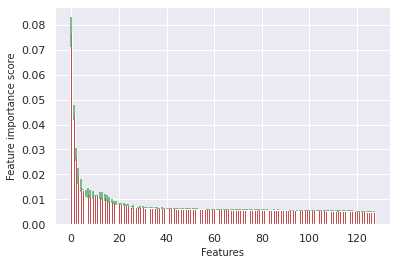

In [21]:
plt.bar(range(features.shape[1]), clf.feature_importances_[sorted_feature_ixs],
       color="r", yerr=deviations[sorted_feature_ixs], ecolor='g')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Feature importance score', fontsize=10)
plt.show()

We can see that only few features are more important. Let's zoom in with only first 10 of the important ones.

Text(0, 0.5, 'Feature importance score')

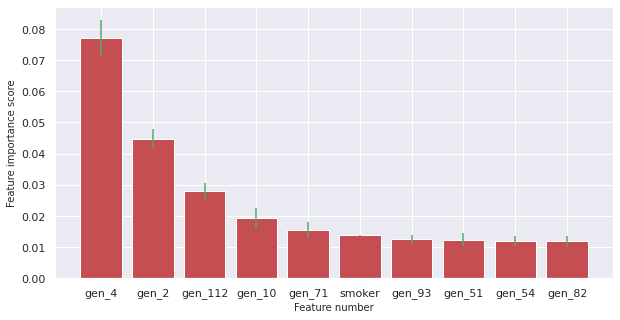

In [36]:
fig, ax = plt.subplots( figsize=(10, 5))
plt.bar(range(10), (clf.feature_importances_[sorted_feature_ixs])[:10],
       color="r", yerr=(deviations[sorted_feature_ixs])[:10], ecolor='g')
plt.xticks(range(10), [X.columns[i] for i in sorted_feature_ixs[:10]])
plt.xlabel('Feature number', fontsize=10)
plt.ylabel('Feature importance score', fontsize=10)
# plt.show()

Looking at the above graph, we can select the first four (i.e., 5,3,113,11) features which are clearly more relevant than others. 

In [23]:
X_imp = X.iloc[:,sorted_feature_ixs[:4]].copy()

Let's do clustering with only these important features.


In [99]:
X_new = pd.concat([X_imp, X.iloc[:,-2:]], axis=1)
X_new = X_new[:1000]
distances = pairwise_distances(X_new, metric=sokalmichener)

<BarContainer object of 7 artists>

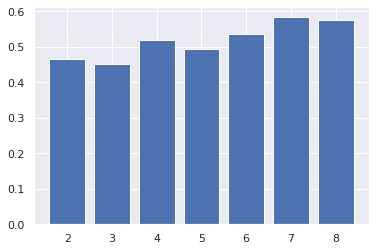

In [100]:
n_cluster = np.arange(1,9)
scores = np.zeros(len(n_cluster))
clusters = np.zeros([len(X_new), len(n_cluster)], dtype=np.int)
for i, n in enumerate(n_cluster):
    clusterer = AgglomerativeClustering(n_clusters=n, affinity='precomputed', 
                                        linkage="average")
    clusters[:,i] = clusterer.fit_predict(distances)
for i in range(1, len(n_cluster)):
    scores[i] = silhouette_score(distances, clusters[:,i], metric='precomputed')
plt.bar(n_cluster[1:], scores[1:])

### Shap values

In [25]:
explainer = shap.TreeExplainer(clf)

In [26]:
expected_value = explainer.expected_value

In [38]:
samples = features.sample(500)
shap_values = explainer.shap_values(samples)

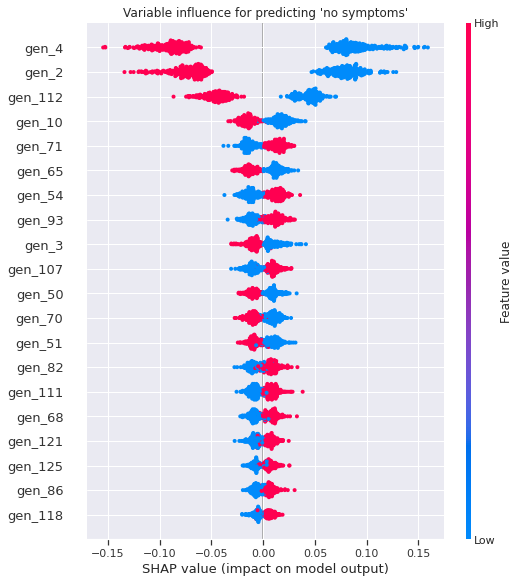

In [104]:
plt.title("Variable influence for predicting 'no symptoms'")
shap.summary_plot(shap_values[0], samples)

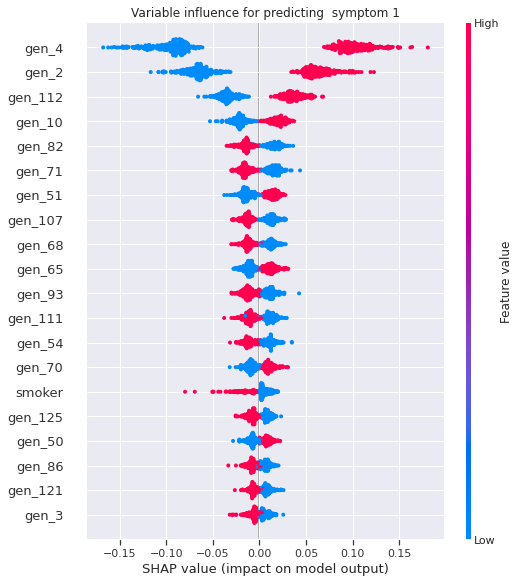

In [105]:
plt.title("Variable influence for predicting  symptom 1")
shap.summary_plot(shap_values[1], samples)

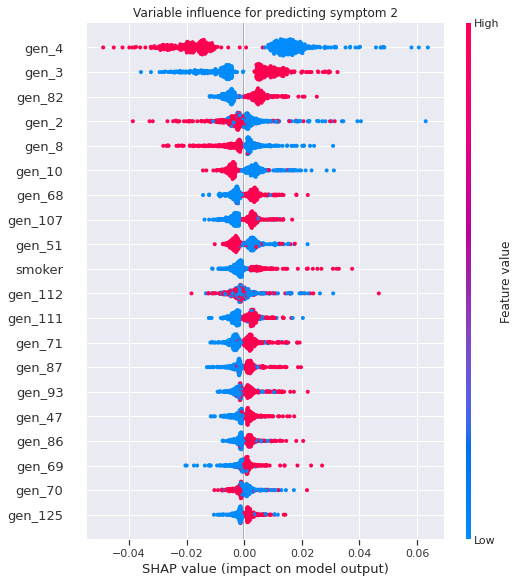

In [106]:
plt.title("Variable influence for predicting symptom 2")
shap.summary_plot(shap_values[2], samples)

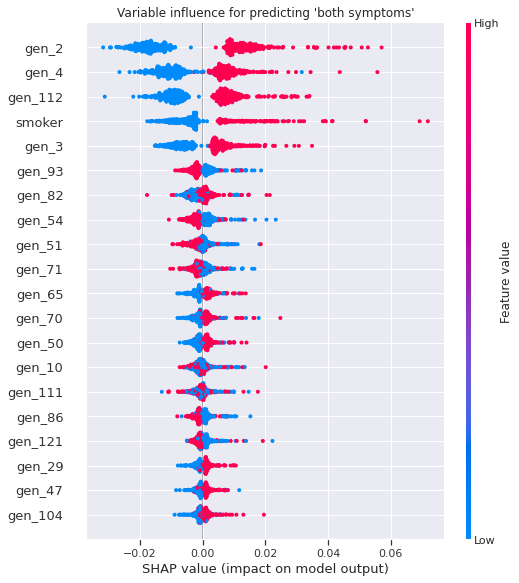

In [107]:
plt.title("Variable influence for predicting 'both symptoms'")
shap.summary_plot(shap_values[3], samples)

(The shap values are only measured on a smaller sample since it takes a lot of time to compute as we're only on the first deadline. Ultimately, we will try to run it on all the data)

Our variety of measurements all point towards the same set of attributes having the biggest impact on likelihood of symptoms. I.e. symptom 1 primarily, but also symptom two to some extent. We conclude that gen_4, gen_2 and gen_112 are worth investigating further

***  

### 1.3 - Measuring the effect of actions

Measuring the effect of actions. We also observe the effects of two different therapeutic
interventions, one of which is placebo, and the other is an experimental drug. Try and measure
the effectiveness of the placebo versus the active treatment. Are there perhaps cases where the
active treatment is never effective, or should it always be recommended?  

***  

In [47]:
# Setup.

a = np.squeeze(A.to_numpy())
y = np.squeeze(Y.to_numpy())
x = X.to_numpy()

gender = x[:, 0]
smoker = x[:, 1]
genes = x[:, 2:127]
symp = x[:, 128:]

The following figure illustrates that action $a_1$ has led to more $y_1$ outcomes compared to action $a_0$. However, both actions $a_0$ and $a_1$ has also led to the outcome $y_0$. Moreover, we observe that the distribution of actions and outcomes is heavily skewed towards $a_1$ and $y_1$, respectively.

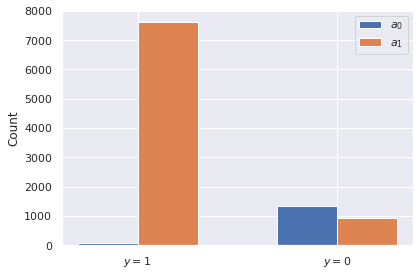

In [48]:
_, axis = plt.subplots(1, 1)

N = 2
ind = np.arange(N)
width = N / 4 - 0.2

rects1 = axis.bar(ind, [sum(y[a == 0]), sum(y[a == 1])], width)
rects2 = axis.bar(ind + width, [sum(y[a == 0] == 0), sum(y[a == 1] == 0)], width)

axis.set_ylabel('Count')
axis.set_xticks(ind + width / 2)
axis.set_xticklabels((r"$y = 1$", r"$y = 0$"))
axis.legend((rects1[0], rects2[0]), ["$a_0$", "$a_1$"])
plt.tight_layout()

## Effect of treatment

Assuming $a_0$ means placebo, $a_1$ is the active treament, $y_1$ is successfull treatment and $y_0$ is un-successfull treatment. To quantify the effectiveness of the placebo $a_0$ versus the active treatment $a_1$ we use the [relative risk score](https://adc.bmj.com/content/90/1/54.full) $RR$. The Bayesian interpretation of this score, namely

$$
RR = \frac{P(y_1 \mid a_1)}{P(y_1 \mid a_0)}
$$

gives the ratio of successfull treatments $P(y_1 \mid a_1)$ divided by the ratio of placebo responders $P(y_1 \mid a_0)$. If $RR > 1$, then $P(y_1 \mid a_1) > P(y_1 \mid a_0)$ in which case the active treatment $a_1$ lead to more successfull outcomes $y_1$ compared to placebo $a_0$.

In [49]:
def rr_score(a, y) -> float:
    """Compute the relative risk score given actions a and outcomes y."""

    p_y1_given_a0 = sum(y[a == 0] == 1) / sum(a == 0)
    p_y1_given_a1 = sum(y[a == 1] == 1) / sum(a == 1)

    return p_y1_given_a1 / p_y1_given_a0

In [50]:
# Measures the effectiveness of the treatment vs. placebo.
print("RR score male:", rr_score(a[gender == 1], y[gender == 1]))
print("RR score female:", rr_score(a[gender == 0], y[gender == 0]))
print("RR score smoker:", rr_score(a[smoker == 1], y[smoker == 1]))
print("RR score non-smoker:", rr_score(a[smoker == 0], y[smoker == 0]))

RR score male: 53.269982993197274
RR score female: 87.31344028520499
RR score smoker: 103.94162538492436
RR score non-smoker: 58.577538284594574


According to the $RR$ acore and assuming $gender = 1$ indicates male (quite common in epidemiology), treatment appears to be more effective on females and smokers than females and non-smokers. Furthermore, we can study the impact of $y_1$ on the gender sub-groups conditioned on whether or not they smoke:

In [51]:
male_idx = gender == 1
female_idx = gender == 0

print("RR smoking male:", rr_score(a[male_idx][smoker[male_idx] == 1], 
                                   y[male_idx][smoker[male_idx] == 1]))

print("RR non-smoking male:", rr_score(a[male_idx][smoker[male_idx] == 0], 
                                       y[male_idx][smoker[male_idx] == 0]))

print("RR smoking female:", rr_score(a[female_idx][smoker[female_idx] == 1], 
                                     y[female_idx][smoker[female_idx] == 1]))

print("RR non-smoking female:", rr_score(a[female_idx][smoker[female_idx] == 0], 
                                         y[female_idx][smoker[female_idx] == 0]))


RR smoking male: 86.69682835820896
RR non-smoking male: 46.00143554407121
RR smoking female: 149.89651022864018
RR non-smoking female: 78.9722969338354


According to the $RR$ scores, we observe across gender that smokers are more responsive to treatment than non-smokers. This could mean that smoking impacts/correlates to the underlying condition targeted by the treatment.

From the data we see that a placebo was given if neither symptom 1 nor 2 were present. However, 30 of these about 4800 cases resulted in a measurable effect of the placebo. 

In [52]:
s1, s2 = symp[:, 0], symp[:, 1]

sum(a[np.logical_and(s1 == 0, s2 == 0)]), sum(y[np.logical_and(s1 == 0, s2 == 0)])

(0, 30)

For active treatment we see that symptom 1 was present in 85\% of the cases when active treatment was successfull compared to symptom 2 being present in only about 27\% of these cases. This means that symptom 1 was present three times more often than symptom 2 when active treatment was successfull. However, a symptom was only present in about 12\% of the cases when active treatment failed. 

In [53]:
p_s1_y1 = sum(s1[np.logical_and(a == 1, y == 1)]) / sum(y)
p_s2_y1 = sum(s2[np.logical_and(a == 1, y == 1)]) / sum(y)
rr_s_y1 = p_s1_y1 / p_s2_y1

p_s1_y1, p_s2_y1, rr_s_y1

(0.8508092892329345, 0.2674173117522871, 3.181578947368421)

## Recommending treatment

We can study the benefits and harms of treatment by consulting a [decision curve](https://www.bmj.com/content/352/bmj.i6). This curve shows the net benefit ($nb$), which is constructed from the true positive rate ($TPR$) and false positve rate ($FPR$) according to
$$
    nb = TPR - FPR \left ( \frac{p_t}{1 - p_t} \right ).
$$
Here we assume that the probability of a positive outcome $p(y_1)$ is given by some prediction model. By comparing $p(y_1)$ to some threshold probability $p_t$ we define a positive outcome as $(y_1) > p_t$. The basic interpretation of a decision curve is that the strategy maximizing $nb$ at a particular $p_t$ probability yields the highest clinical value. 

In [54]:
# Gives proba of y1 given a1.
clf.fit(x[a == 1], y[a == 1])
pred_probas = clf.predict_proba(x[a == 1])[:, 1]

y_true = y[a == 1]

In [55]:
def net_benefit(y_true, probas, p_t):
    # https://www.bmj.com/content/352/bmj.i6
    
    y_pred = probas >= p_t
    
    tpr = sum(y_pred == y_true) / len(y_true)
    fpr = sum(y_pred != y_true) / len(y_true)
    
    return tpr - fpr * p_t / (1 - p_t)

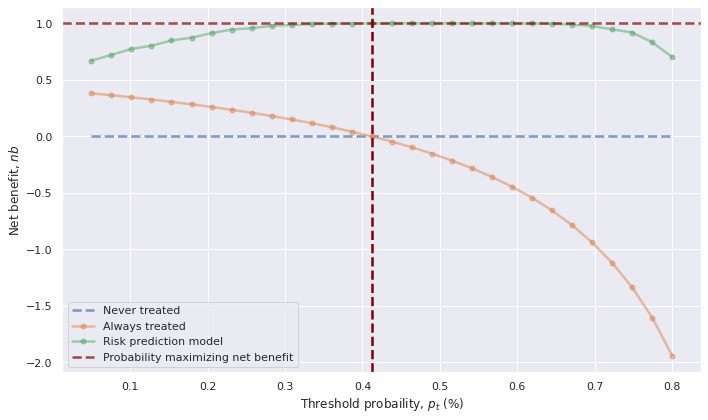

In [56]:
thresholds = np.linspace(0.05, 0.8, 30)
net_benefits = [net_benefit(y_true, pred_probas, p) for p in thresholds]
always_treated = [net_benefit(y_true, 0, p) for p in thresholds]

plt.figure(figsize=(10, 6))
plt.plot([min(thresholds), max(thresholds)], [0, 0], linestyle="--", label="Never treated", 
         alpha=0.7, linewidth=2.5)
plt.plot(thresholds, always_treated, "o-", label="Always treated", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.plot(thresholds, net_benefits, "o-", label="Risk prediction model", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.axvline(x=thresholds[np.argmax(net_benefits)], linestyle="--", c="maroon", linewidth=2.5)
plt.axhline(y=np.max(net_benefits), linestyle="--", linewidth=2.5,
            label="Probability maximizing net benefit", c="maroon", alpha=0.7)
plt.ylabel("Net benefit, $nb$")
plt.xlabel(r"Threshold probaility, $p_t$ ($\%$)")
plt.legend()
plt.tight_layout()

For this case, the decision curve shows that the prediction model gives higher benefit across all thresholds comapred to always treating individuals. Due to the imbalanced outcomes where $y_1$ outnumbers $y_0$, always treating individuals does not give a higher number of false positives than true positives meaning that $nb > 0$ for $p_t < 75 \%$. Moreover, using a threshold $p_t > 55 \%$ to issue treatment leads to a decrease in $nb$ from fewer true positives and considering a $p_t$ between $40 - 50 \%$ for $p(y_1)$ given $a_1$ gives the higest $nb$.

## Part 2 - Improved Policy

## Part 3 - Adaptive experiment design